Making of the neural network, training of the neural network, and testing on various model happens here.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn.functional import relu

U-net model

In [2]:
from unet_extra_extra_conv import UNet

Load the alphabets.

In [3]:
import pickle

alpha = {}
dirty_alpha = {}
with open('../Input_Representation/data/other/alphabet.pkl', 'rb') as f:
    alpha = pickle.load(f)
with open('../Input_Representation/data/other/dirty_alphabet.pkl', 'rb') as f:
    dirty_alpha = pickle.load(f)


Making the dataset and making the Dataloader.

In [4]:
import torchvision

class transpose:
    def __init__(self):
        pass

    def __call__(self, sample):
        return sample.T

class flatten:
    def __init__(self):
        pass

    def __call__(self, sample):
        new_sample = sample.flatten()

transform = torchvision.transforms.Compose([transpose(), flatten(), transpose()])

In [5]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    '''
    Contains the dataset.
    '''
    # def __init__(self, alpha, dirty_alpha, transform=None):
    #     '''
    #     Initialize the dataset.
    #     '''
    #     self.data = []
    #     self.labels = []
    #     for key, value in alpha.items():
    #         if key in dirty_alpha:
    #             for i, stroke in enumerate(dirty_alpha[key]):
    #                 self.labels.append(torch.Tensor(value[0]))
    #                 self.data.append(torch.Tensor(stroke))
    #         else:
    #             continue
    #     self.data = np.array(self.data, dtype=torch.Tensor)
    #     self.labels = np.array(self.labels, dtype=torch.Tensor)

    def __init__(self, alpha, dirty_alpha, transform=None):
        '''
        Initialize the dataset.
        '''
        self.data = []
        self.labels = []
        self.n = 10
        for key, value in alpha.items():
            if key in dirty_alpha:
                for i, stroke in enumerate(dirty_alpha[key]):
                    self.labels.append(torch.Tensor(value[0]))
                    self.data.append(torch.Tensor(stroke))
            else:
                continue

    def __getitem__(self, index):
        x = self.data[index // self.n]
        y = self.labels[index // self.n]
        return x, y

    def __len__(self):
        return len(self.data)*self.n

dataset = MyDataset(alpha, dirty_alpha)
# dataset_test = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
dataloader = DataLoader(dataset=dataset, batch_size=72, shuffle=True, num_workers=1)

torch.Size([72, 3, 256]) torch.Size([72, 3, 256])


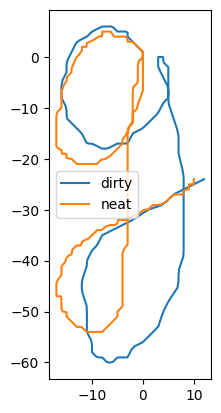

In [6]:
dataiter = iter(dataloader)
data = next(dataiter)
features, labels = data
print(features.shape, labels.shape)
print(features[0].numpy())

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(features[0].numpy()[0], features[0].numpy()[1]*-1, label="dirty")
ax.plot(labels[0].numpy()[0], labels[0].numpy()[1]*-1, label="neat")
ax.set_aspect('equal', adjustable='box')
ax.legend()
plt.show()

In [7]:
def interpolate(stroke, length):
        '''
        This funtion takes a normal input stroke and returns a stroke 
        with the a contant length of "len" using linear interpolation.
        '''
        x, y, p = stroke
        size = stroke.shape[1]
        interp_x = np.interp(np.linspace(0, size, length, endpoint=True), np.arange(size), x)
        interp_y = np.interp(np.linspace(0, size, length, endpoint=True), np.arange(size), y)
        interp_p = np.interp(np.linspace(0, size, length, endpoint=True), np.arange(size), p)
        return np.stack([interp_x, interp_y, interp_p], axis=0)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

num_epochs = 100
learning_rate = 0.0005

model = UNet(3).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = len(dataloader)
losses = []
for epoch in range(num_epochs):
    for i, (features, labels) in enumerate(dataloader):
        features = features.to(device)
        labels = labels.to(device)

        # forward pass
        # outputs = torch.Tensor([interpolate(stroke, 252) for stroke in model(features).detach().numpy()])
        outputs = model(features)
        loss = criterion(outputs.requires_grad_(), labels)
        losses.append(loss.item())

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 1 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

torch.save(model.state_dict(), 'modelxxc.ckpt')


cuda
Epoch [1/100], Step [1/51], Loss: 271.4885
Epoch [1/100], Step [2/51], Loss: 297.3893
Epoch [1/100], Step [3/51], Loss: 283.1463
Epoch [1/100], Step [4/51], Loss: 256.6118
Epoch [1/100], Step [5/51], Loss: 298.5930
Epoch [1/100], Step [6/51], Loss: 281.0417
Epoch [1/100], Step [7/51], Loss: 293.2593
Epoch [1/100], Step [8/51], Loss: 296.0183
Epoch [1/100], Step [9/51], Loss: 275.4630
Epoch [1/100], Step [10/51], Loss: 305.6883
Epoch [1/100], Step [11/51], Loss: 284.8465
Epoch [1/100], Step [12/51], Loss: 271.6552
Epoch [1/100], Step [13/51], Loss: 246.4841
Epoch [1/100], Step [14/51], Loss: 276.4414
Epoch [1/100], Step [15/51], Loss: 247.0202
Epoch [1/100], Step [16/51], Loss: 249.2394
Epoch [1/100], Step [17/51], Loss: 277.7733
Epoch [1/100], Step [18/51], Loss: 281.5155
Epoch [1/100], Step [19/51], Loss: 240.8368
Epoch [1/100], Step [20/51], Loss: 252.4559
Epoch [1/100], Step [21/51], Loss: 237.7062
Epoch [1/100], Step [22/51], Loss: 191.0506
Epoch [1/100], Step [23/51], Loss: 6

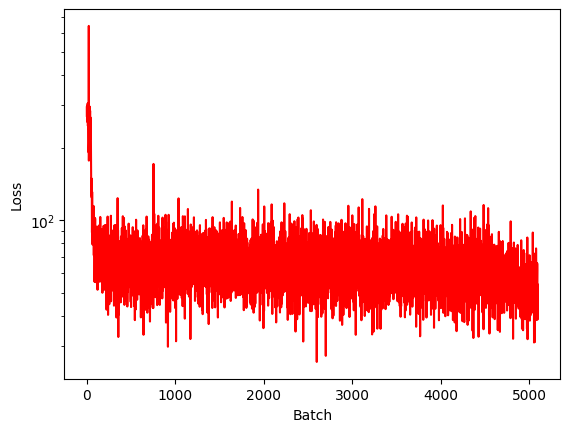

<Figure size 640x480 with 0 Axes>

In [9]:
fig = plt.figure()
plt.plot(losses, color='red')
plt.yscale('log')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()
plt.savefig('figs/loss_xxc.png')

/tmp/ipykernel_3967/2806640001.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


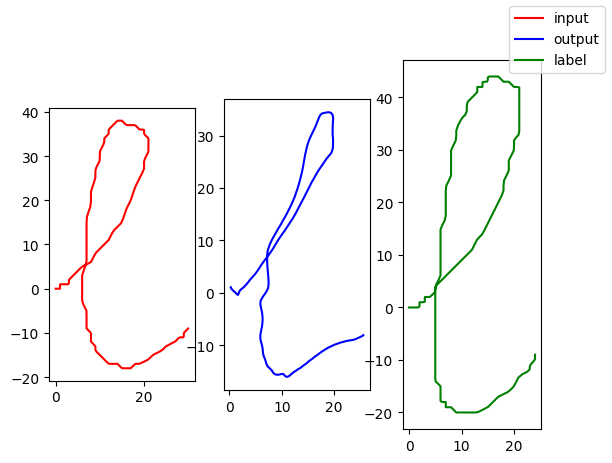

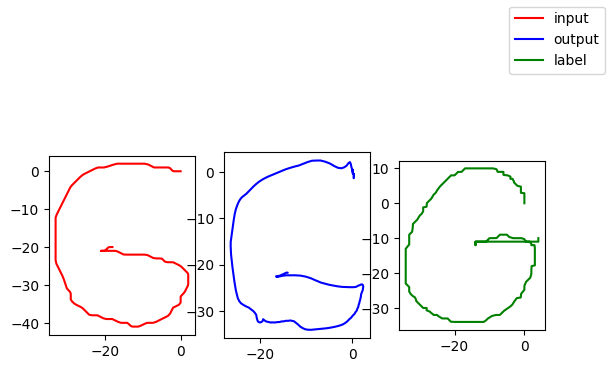

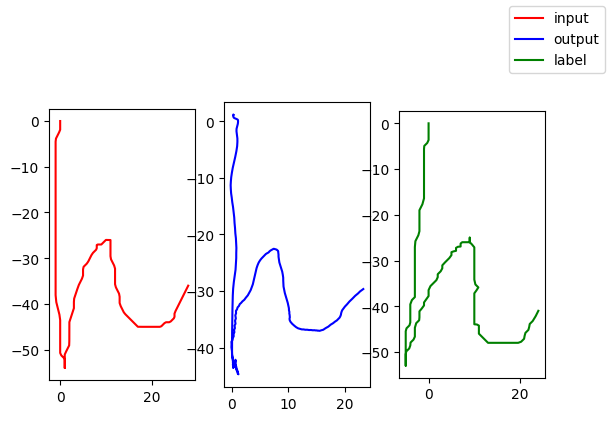

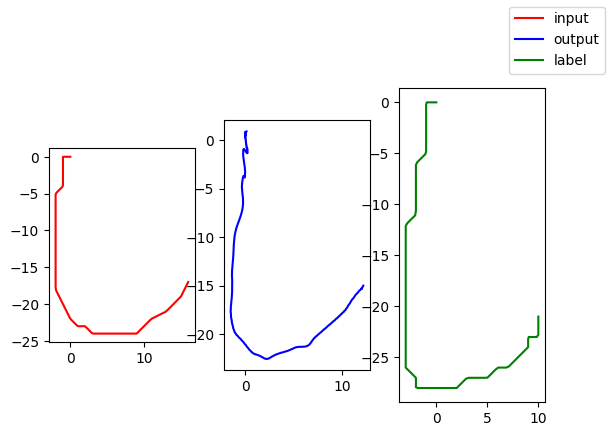

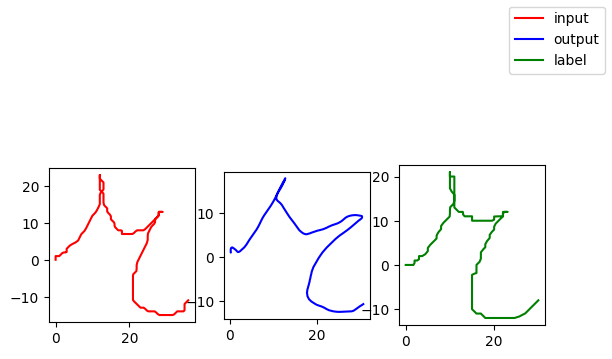

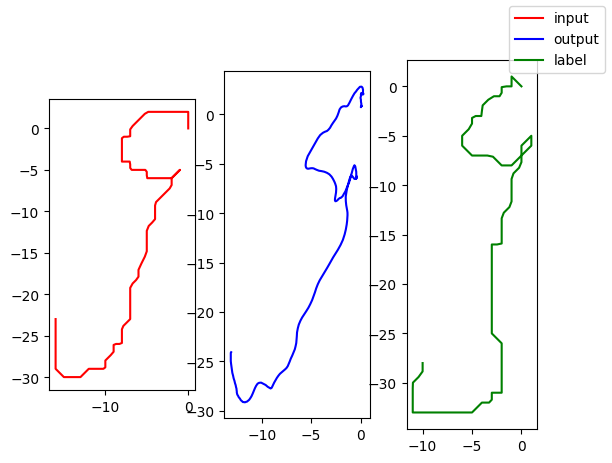

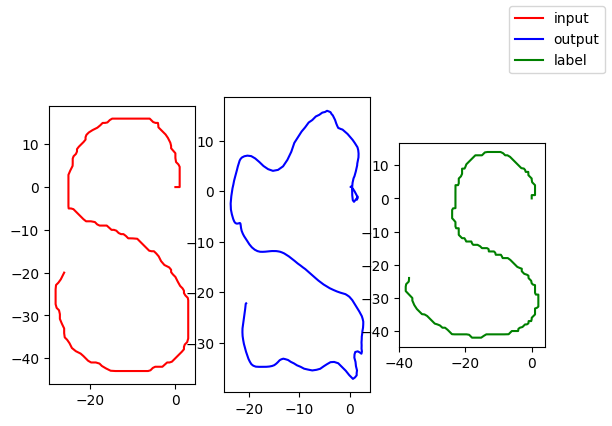

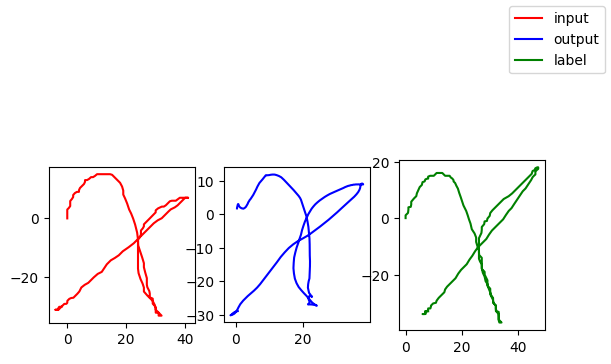

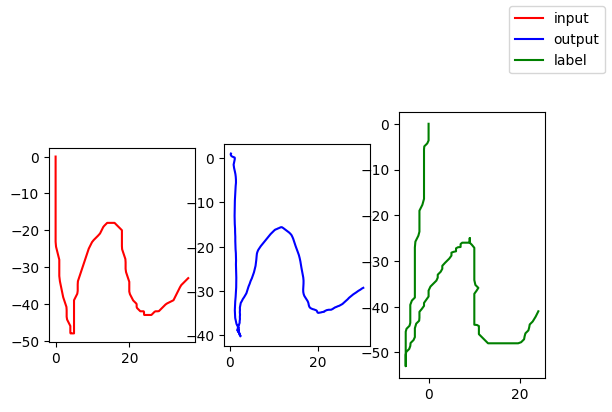

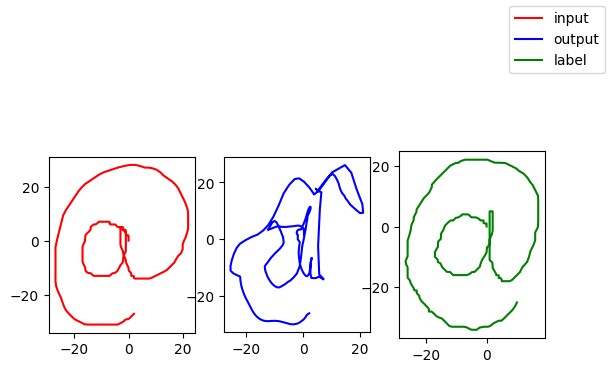

In [13]:

dataiter = iter(dataloader)
model = model.to("cpu")

n = 0
for data in dataiter:
    if n == 10:
        break
    features, labels = data
    outputs = model(features)
    outputs = outputs.to("cpu")

    fig = plt.figure()
    ax = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)
    
    ax.plot(features[0].numpy()[0], features[0].numpy()[1]*-1, color="red", label="input")
    ax2.plot(outputs[0].detach().numpy()[0], outputs[0].detach().numpy()[1]*-1, color="blue", label="output")
    ax3.plot(labels[0].numpy()[0], labels[0].numpy()[1]*-1, color="green", label="label")
    ax.set_aspect('equal', adjustable='box')
    ax2.set_aspect('equal', adjustable='box')
    ax3.set_aspect('equal', adjustable='box')
    fig.legend()

    n += 1
    fig.show()



In [ ]:
# dataiter = iter(dataloader)
# data = next(dataiter)
# data2 = next(dataiter)
# data3 = next(dataiter)
# data4 = next(dataiter)
# data5 = next(dataiter)
# features, labels = data
# features2, labels2 = data2
# features3, labels3 = data3
# features4, labels4 = data4
# features5, labels5 = data5
# output_features = model(features)
# output_features2 = model(features2)
# output_features3 = model(features3)
# output_features4 = model(features4)
# output_features5 = model(features5)

# fig = plt.figure()
# ax = fig.add_subplot(531)
# ax2 = fig.add_subplot(532)
# ax3 = fig.add_subplot(533)
# ax4 = fig.add_subplot(534)
# ax5 = fig.add_subplot(535)
# ax6 = fig.add_subplot(536)
# ax7 = fig.add_subplot(537)
# ax8 = fig.add_subplot(538)
# ax9 = fig.add_subplot(539)
# ax10 = fig.add_subplot(5,3,10)
# ax11 = fig.add_subplot(5,3,11)
# ax12 = fig.add_subplot(5,3,12)
# ax13 = fig.add_subplot(5,3,13)
# ax14 = fig.add_subplot(5,3,14)
# ax15 = fig.add_subplot(5,3,15)



# ax4.plot(features2[0].numpy()[0], features2[0].numpy()[1]*-1, color="red", label="input")
# ax5.plot(output_features2[0].detach().numpy()[0], output_features2[0].detach().numpy()[1]*-1, color="blue", label="output")
# ax6.plot(labels2[0].numpy()[0], labels2[0].numpy()[1]*-1, color="green", label="label")

# ax7.plot(features3[0].numpy()[0], features3[0].numpy()[1]*-1, color="red", label="input")
# ax8.plot(output_features3[0].detach().numpy()[0], output_features3[0].detach().numpy()[1]*-1, color="blue", label="output")
# ax9.plot(labels3[0].numpy()[0], labels3[0].numpy()[1]*-1, color="green", label="label")

# ax10.plot(features4[0].numpy()[0], features4[0].numpy()[1]*-1, color="red", label="input")
# ax11.plot(output_features4[0].detach().numpy()[0], output_features4[0].detach().numpy()[1]*-1, color="blue", label="output")
# ax12.plot(labels4[0].numpy()[0], labels4[0].numpy()[1]*-1, color="green", label="label")

# ax13.plot(features5[0].numpy()[0], features5[0].numpy()[1]*-1, color="red", label="input")
# ax14.plot(output_features5[0].detach().numpy()[0], output_features5[0].detach().numpy()[1]*-1, color="blue", label="output")
# ax15.plot(labels5[0].numpy()[0], labels5[0].numpy()[1]*-1, color="green", label="label")


# ax4.set_aspect('equal', adjustable='box')
# ax5.set_aspect('equal', adjustable='box')
# ax6.set_aspect('equal', adjustable='box')
# ax7.set_aspect('equal', adjustable='box')
# ax8.set_aspect('equal', adjustable='box')
# ax9.set_aspect('equal', adjustable='box')
# ax10.set_aspect('equal', adjustable='box')
# ax11.set_aspect('equal', adjustable='box')
# ax12.set_aspect('equal', adjustable='box')
# ax13.set_aspect('equal', adjustable='box')
# ax14.set_aspect('equal', adjustable='box')
# ax15.set_aspect('equal', adjustable='box')

# plt.legend()
# plt.show()